In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
# from scipy.stats import norm
import pyarrow.parquet as pq
import pandas as pd

# Loading in data and prepping for analysis

In [2]:
# Read in parquet file 
table = pq.read_table("/Users/167011/Documents/MQF/Thesis/Deribit_Data/deribit_options_2025-01-30_100k_rows.parquet")

# table = pq.read_table("/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet")
# Convert to Panadas DataFrame
df = table.to_pandas()

# Seperate Option Type, Strike and Maturity
df[['asset', 'expiry', 'strike', 'option_type']] = df['instrument_name'].str.split('-', expand=True)

# Define log-price to ensure positive values
df['log_price'] = np.log(df['underlying_price'])
# Define log-return
df['log_return'] = df['log_price'].diff().fillna(0)

# Define maturity in years
df['expiry'] = pd.to_datetime(df['expiry'])
reference_date = pd.to_datetime("2025-01-30")
df['time_to_maturity'] = (df['expiry'] - reference_date).dt.days / 252

# Group the DataFrame by 'time_stamp' and count unique 'time_to_maturity' values for each group
unique_counts = df.groupby('timestamp')['strike'].nunique()

# Identify the timestamp with the highest count of unique 'time_to_maturity' values
max_timestamp = unique_counts.idxmax()
max_count = unique_counts[max_timestamp]

# Snapshot where the count of unique 'time_to_maturity' values is highest
snapshot = df[(df['timestamp'] == max_timestamp) & (df['option_type'] == 'C')]

# Convert 'strike' to numeric
snapshot['strike'] = pd.to_numeric(snapshot['strike'], errors='coerce')

snapshot['mid_price'] = ((snapshot['best_bid_price'] + snapshot['best_ask_price']) / 2) # *snapshot['index_price']
snapshot['mark_price_usd'] = snapshot['mark_price']*snapshot['index_price']

snapshot = snapshot[['time_to_maturity', 'strike', 'mid_price', 'mark_price_usd', 'index_price']]

# print(snapshot)

options_df = snapshot.copy()

options_df['maturity'] = options_df['time_to_maturity']
options_df['mid_market'] = options_df['mid_price'] 
options_df['underlying'] = options_df['index_price']
options_df['strike'] = options_df['strike']/ options_df['underlying']
options_df['underlying'] = 1



options_df = options_df[['maturity', 'strike', 'mid_market', 'underlying']]

print(options_df)

options_df = options_df.astype({
    'maturity': 'float32',
    'strike': 'float32',
    'mid_market': 'float32',
    'underlying': 'float32'
})

       maturity    strike  mid_market  underlying
31951  0.226190  1.253123     0.02750           1
31959  0.226190  1.445911     0.01150           1
31961  0.226190  1.542305     0.00800           1
31963  0.226190  1.638699     0.00600           1
31965  0.226190  1.686896     0.00515           1
31967  0.226190  1.735093     0.00455           1
31969  0.226190  1.927882     0.00270           1
31973  0.226190  2.409852     0.00140           1
31975  0.226190  2.891822     0.00075           1
31977  0.587302  0.192788     0.81650           1
31979  0.587302  0.289182     0.72550           1
31981  0.587302  0.385576     0.63525           1
31983  0.587302  0.433773     0.59025           1
31985  0.587302  0.481970     0.54575           1
31987  0.587302  0.530167     0.50200           1
31989  0.587302  0.578364     0.45875           1
31991  0.587302  0.626562     0.41675           1
31993  0.587302  0.674759     0.37600           1
31995  0.587302  0.722956     0.33725           1


/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_89322/231799447.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_89322/231799447.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot['strike'] = pd.to_numeric(snapshot['strike'], errors='coerce')
/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_89322/231799447.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

# This is the Neural SDE model with a generative adversarial network calibration method

Epoch 0: T=0.2261904776096344: RobustGenLoss=0.0147, T=0.5873016119003296: RobustGenLoss=0.0098
Epoch 50: T=0.2261904776096344: RobustGenLoss=0.0000, T=0.5873016119003296: RobustGenLoss=0.0003
Epoch 100: T=0.2261904776096344: RobustGenLoss=0.0000, T=0.5873016119003296: RobustGenLoss=0.0003
Epoch 150: T=0.2261904776096344: RobustGenLoss=0.0000, T=0.5873016119003296: RobustGenLoss=0.0002
Epoch 200: T=0.2261904776096344: RobustGenLoss=0.0000, T=0.5873016119003296: RobustGenLoss=0.0002
Epoch 250: T=0.2261904776096344: RobustGenLoss=0.0000, T=0.5873016119003296: RobustGenLoss=0.0002
Epoch 300: T=0.2261904776096344: RobustGenLoss=0.0000, T=0.5873016119003296: RobustGenLoss=0.0001
Epoch 350: T=0.2261904776096344: RobustGenLoss=0.0000, T=0.5873016119003296: RobustGenLoss=0.0002
Epoch 400: T=0.2261904776096344: RobustGenLoss=0.0000, T=0.5873016119003296: RobustGenLoss=0.0001
Epoch 450: T=0.2261904776096344: RobustGenLoss=0.0000, T=0.5873016119003296: RobustGenLoss=0.0001


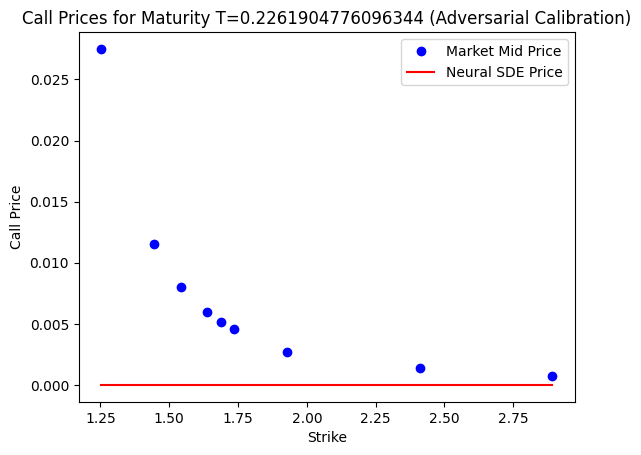

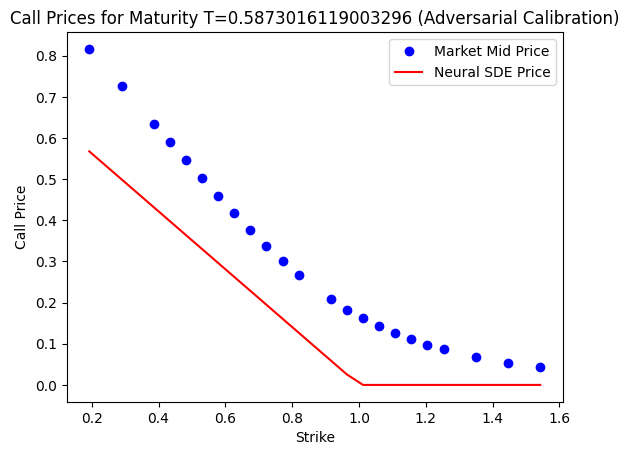

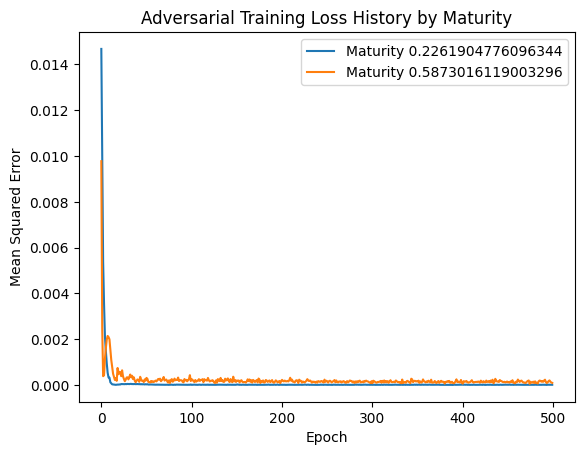

In [ ]:

# Global model parameters
r = 0.00             # risk-free rate
nu = 0.5             # vol of vol
rho = -0.3           # correlation between dW and dB
alpha0 = 0.6         # initial stochastic vol level
# Underlying price (always 1.0 for normalized data)
S0 = options_df['underlying'].iloc[0]  # initial asset price
 

def build_leverage_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(2,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='tanh'))
    model.add(layers.Lambda(lambda x: 2.0 + 2.0 * x))
    return model

unique_maturities = options_df['maturity'].unique()
leverage_models = {T: build_leverage_model() for T in unique_maturities}
optimizer_dict = {T: optimizers.Adam(learning_rate=0.01) for T in unique_maturities}

def bs_delta(S, K, T, r, sigma):
    d1 = (tf.math.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * tf.math.sqrt(T))
    norm_cdf = 0.5 * (1.0 + tf.math.erf(d1 / tf.sqrt(2.0)))
    return 0
    # return tf.exp(-r*T) * norm_cdf

# @tf.function
def simulate_S_paths(T, num_steps, num_paths, S0, sigma, leverage_model):
    dt = T / num_steps
    S = tf.fill([num_paths], S0)
    for i in range(num_steps):
        t_val = (i+1) * dt
        t_tensor = tf.fill([num_paths, 1], t_val)
        S_tensor = tf.reshape(S, (-1, 1))
        inp = tf.concat([t_tensor, S_tensor], axis=1)
        L_val = leverage_model(inp)
        L_val = tf.reshape(L_val, [-1])
        dW = tf.random.normal([num_paths], mean=0.0, stddev=tf.sqrt(dt))
        S = S + S * sigma * L_val * dW
    return S

# @tf.function
def monte_carlo_call_price(T, K, S0, r, sigma, leverage_model, num_steps=100, num_paths=5000):
    S_T = simulate_S_paths(T, num_steps, num_paths, S0, sigma, leverage_model)
    call_payoff = tf.nn.relu(S_T - K)
    delta = bs_delta(S_T, K, T, r, sigma)
    control_variate = delta * (S_T - S0)
    c = 1.0
    adjusted_payoff = call_payoff - c * control_variate
    price = tf.exp(-r * T) * tf.reduce_mean(adjusted_payoff)
    return price

def robust_loss(model_price, market_price, perturbation=0.001, num_candidates=4):
    candidates = [
        market_price * (1 + delta)
        for delta in np.linspace(-perturbation, perturbation, num_candidates)
    ]
    candidate_losses = [tf.square(model_price - cand) for cand in candidates]
    return tf.reduce_max(tf.stack(candidate_losses))

num_epochs = 500
adv_loss_history = {T: [] for T in unique_maturities}

for epoch in range(num_epochs):
    loss_total_by_T = {T: 0.0 for T in unique_maturities}
    count_by_T = {T: 0 for T in unique_maturities}
    gen_loss_dict = {}
    with tf.GradientTape(persistent=True) as tape_gen:
        for idx, row in options_df.iterrows():
            T = float(row['maturity'])
            K = float(row['strike'])
            market_price = float(row['mid_market'])
            model_net = leverage_models[T]
            model_price = monte_carlo_call_price(
                T, K, S0, r, alpha0, model_net,
                num_steps=100, num_paths=1000
            )
            option_loss = robust_loss(model_price, market_price)
            loss_total_by_T[T] += option_loss
            count_by_T[T] += 1
        for T in unique_maturities:
            if count_by_T[T] > 0:
                loss_total_by_T[T] /= count_by_T[T]
            gen_loss_dict[T] = loss_total_by_T[T]

    for T in unique_maturities:
        model = leverage_models[T]
        grads_gen = tape_gen.gradient(gen_loss_dict[T], model.trainable_variables)
        optimizer_dict[T].apply_gradients(zip(grads_gen, model.trainable_variables))
        adv_loss_history[T].append(gen_loss_dict[T].numpy())
    del tape_gen

    if epoch % 50 == 0:
        losses_str = ", ".join(
            [f"T={T}: RobustGenLoss={gen_loss_dict[T].numpy():.4f}"
             for T in unique_maturities]
        )
        print(f"Epoch {epoch}: {losses_str}")

model_prices = []
for idx, row in options_df.iterrows():
    T = float(row['maturity'])
    K = float(row['strike'])
    model_net = leverage_models[T]
    price = monte_carlo_call_price(
        T, K, S0, r, alpha0, model_net,
        num_steps=100, num_paths=5000
    )
    model_prices.append(price.numpy())

options_df['model_price'] = model_prices
 
# Plot calibration results (market vs. model prices) for each maturity.
for T_val in options_df['maturity'].unique():
    subset = options_df[options_df['maturity'] == T_val]
    plt.figure()
    plt.plot(subset['strike'], subset['mid_market'], 'bo', label='Market Mid Price')
    plt.plot(subset['strike'], subset['model_price'], 'r-', label='Neural SDE Price')
    plt.title(f'Call Prices for Maturity T={T_val} (Adversarial Calibration)')
    plt.xlabel('Strike')
    plt.ylabel('Call Price')
    plt.legend()
    plt.show()
 
# Plot training loss history for each maturity.
plt.figure()
for T in unique_maturities:
    plt.plot(adv_loss_history[T], label=f'Maturity {T}')
plt.title("Adversarial Training Loss History by Maturity")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()

plt.show()



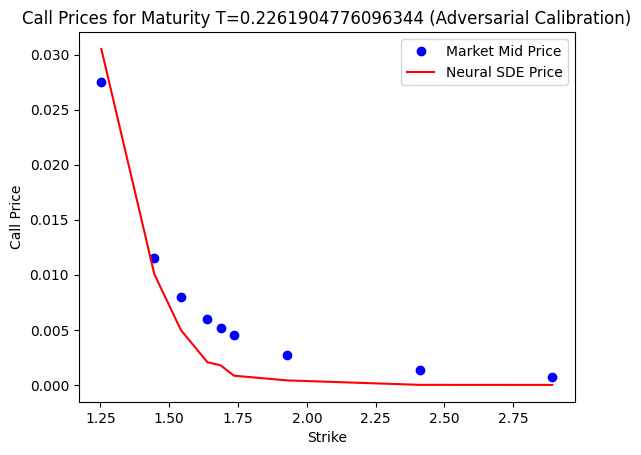

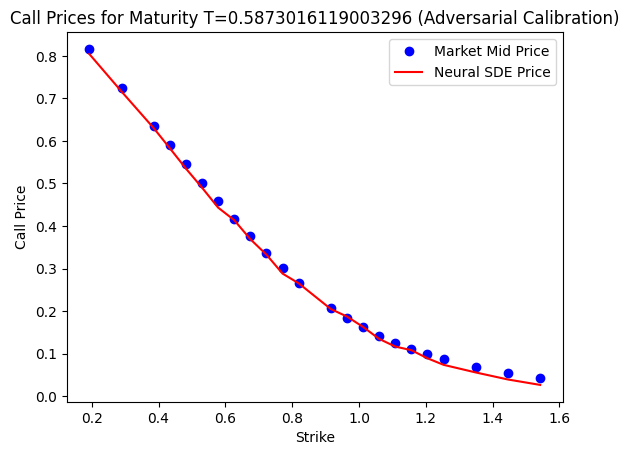

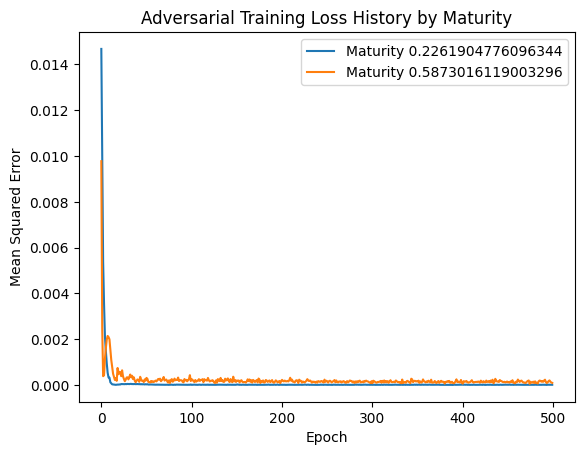

In [11]:
model_prices = []
for idx, row in options_df.iterrows():
    T = float(row['maturity'])
    K = float(row['strike'])
    model_net = leverage_models[T]
    price = monte_carlo_call_price(
        T, K, S0, r, alpha0, model_net,
        num_steps=100, num_paths=5000
    )
    model_prices.append(price.numpy())

options_df['model_price'] = model_prices
 
# Plot calibration results (market vs. model prices) for each maturity.
for T_val in options_df['maturity'].unique():
    subset = options_df[options_df['maturity'] == T_val]
    plt.figure()
    plt.plot(subset['strike'], subset['mid_market'], 'bo', label='Market Mid Price')
    plt.plot(subset['strike'], subset['model_price'], 'r-', label='Neural SDE Price')
    plt.title(f'Call Prices for Maturity T={T_val} (Adversarial Calibration)')
    plt.xlabel('Strike')
    plt.ylabel('Call Price')
    plt.legend()
    plt.show()
 
# Plot training loss history for each maturity.
plt.figure()
for T in unique_maturities:
    plt.plot(adv_loss_history[T], label=f'Maturity {T}')
plt.title("Adversarial Training Loss History by Maturity")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()

plt.show()

